# Setup Depedencies

Imports various libraries to support data processing and deep learning model training. Libraries such as `os`, `pandas`, and `numpy` are used for data manipulation, while `matplotlib` and `seaborn` help with visualization. OpenCV (`cv2`) is used for image manipulation, while TensorFlow and Keras provide tools for building and training deep learning models. Transfer learning with MobileNetV2 was used to improve accuracy, supplemented by data augmentation using `ImageDataGenerator`. Model evaluation is performed using metrics such as confusion matrix and classification report, and the `shutil` library helps with file and directory management during the process.

Translated with DeepL.com (free version)

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

# Get Data

Access files and folders stored in Google Drive directly from the Colab environment

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataDirList = ['/content/drive/MyDrive/Capstone/garbage_classification/data']

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

# Proses Data

In [4]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)

# Convert the 2 lists to dataframe to easy use
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

imgPath      label
0     /content/drive/MyDrive/Capstone/garbage_classi...      trash
1     /content/drive/MyDrive/Capstone/garbage_classi...      metal
2     /content/drive/MyDrive/Capstone/garbage_classi...      paper
3     /content/drive/MyDrive/Capstone/garbage_classi...      glass
4     /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
...                                                 ...        ...
6318  /content/drive/MyDrive/Capstone/garbage_classi...      glass
6319  /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
6320  /content/drive/MyDrive/Capstone/garbage_classi...      metal
6321  /content/drive/MyDrive/Capstone/garbage_classi...      trash
6322  /content/drive/MyDrive/Capstone/garbage_classi...      glass

[6323 rows x 2 columns]

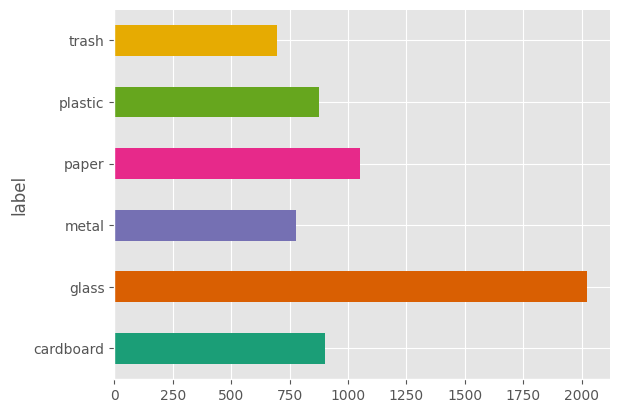

In [5]:
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# get the ratio such as 15% of each class for testing
def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [7]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)
trainDf

imgPath      label
0     /content/drive/MyDrive/Capstone/garbage_classi...      trash
1     /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
2     /content/drive/MyDrive/Capstone/garbage_classi...      paper
3     /content/drive/MyDrive/Capstone/garbage_classi...      metal
4     /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
...                                                 ...        ...
5366  /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
5367  /content/drive/MyDrive/Capstone/garbage_classi...      glass
5368  /content/drive/MyDrive/Capstone/garbage_classi...      paper
5369  /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
5370  /content/drive/MyDrive/Capstone/garbage_classi...  cardboard

[5371 rows x 2 columns]

In [8]:
trainDf['label'].value_counts()

label
glass        1717
paper         892
cardboard     765
plastic       743
metal         662
trash         592
Name: count, dtype: int64

In [9]:
testDf

imgPath      label
0    /content/drive/MyDrive/Capstone/garbage_classi...      glass
1    /content/drive/MyDrive/Capstone/garbage_classi...      paper
2    /content/drive/MyDrive/Capstone/garbage_classi...      glass
3    /content/drive/MyDrive/Capstone/garbage_classi...    plastic
4    /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
..                                                 ...        ...
947  /content/drive/MyDrive/Capstone/garbage_classi...      paper
948  /content/drive/MyDrive/Capstone/garbage_classi...      glass
949  /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
950  /content/drive/MyDrive/Capstone/garbage_classi...  cardboard
951  /content/drive/MyDrive/Capstone/garbage_classi...      trash

[952 rows x 2 columns]

In [10]:
testDf['label'].value_counts()

label
glass        304
paper        158
cardboard    136
plastic      132
metal        117
trash        105
Name: count, dtype: int64

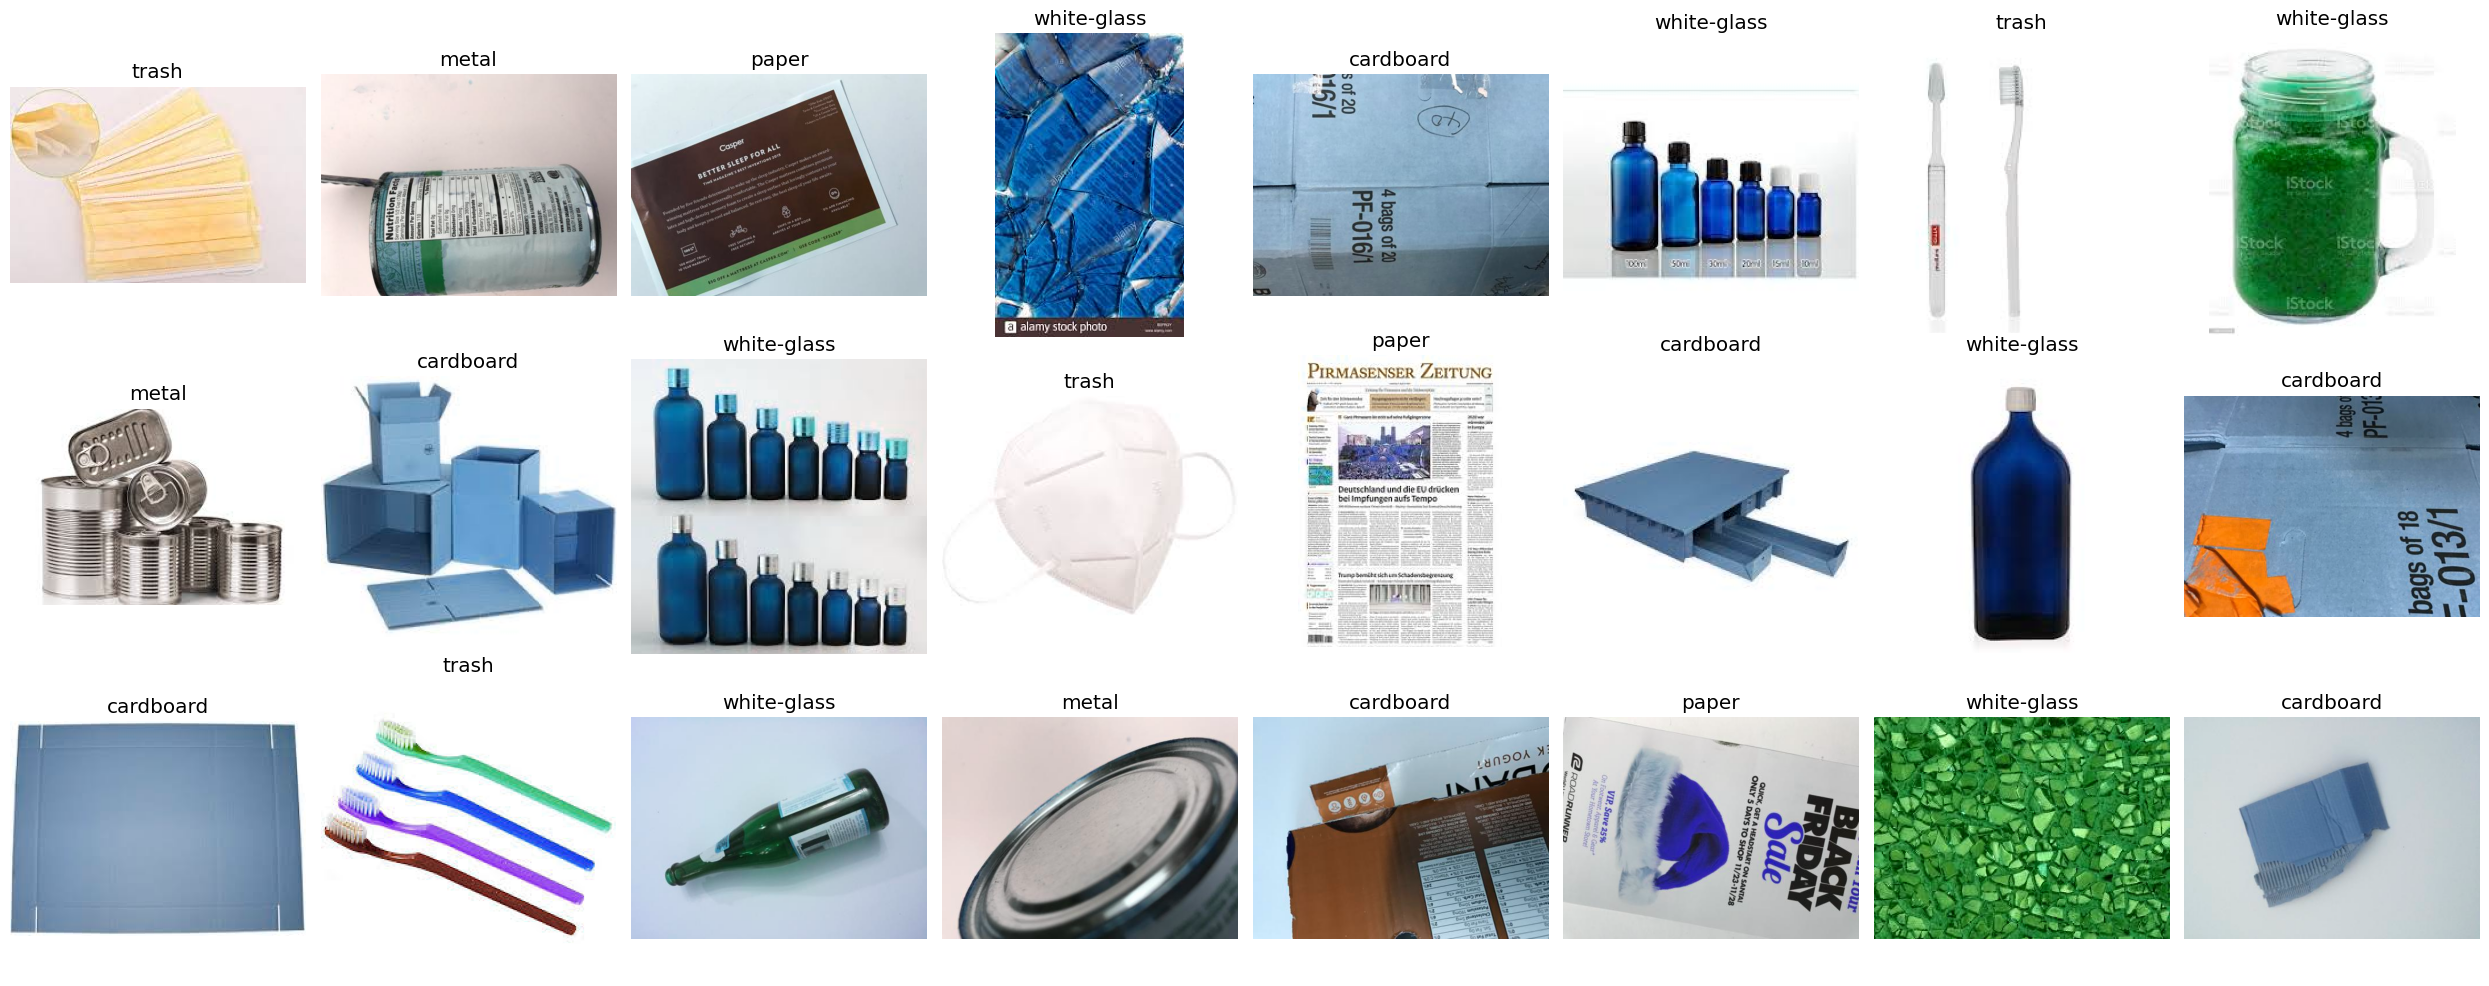

In [11]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Setup Training

In [12]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [13]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 5371 validated image filenames belonging to 6 classes.
Found 952 validated image filenames belonging to 6 classes.
Training set size: 5371
Testing set size: 952


In [14]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([

#         Resizing(IMG_SIZE),

#         Rescaling(1./255),     These two steps ,we did perform them above with test and image generator

        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),

        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False

        Dense(64,activation='relu'),

        BatchNormalization(),

        Dropout(0.08),

        Dense(6 ,activation='softmax')
    ])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [16]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [17]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [21]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator,
                    epochs=50,
#                     batch_size=64,   # we define it above inside trainGenerator
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2176s 24s/step - accuracy: 0.7026 - loss: 0.8446 - val_accuracy: 0.8887 - val_loss: 0.3618
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 100s 970ms/step - accuracy: 0.8875 - loss: 0.3228 - val_accuracy: 0.8887 - val_loss: 0.3410
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 90s 997ms/step - accuracy: 0.9032 - loss: 0.2634 - val_accuracy: 0.8855 - val_loss: 0.3354
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 974ms/step - accuracy: 0.9276 - loss: 0.2074 - val_accuracy: 0.8939 - val_loss: 0.3493
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 984ms/step - accuracy: 0.9431 - loss: 0.1722 - val_accuracy: 0.9086 - val_loss: 0.3018
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 90s 984ms/step - accuracy: 0.9376 - loss: 0.1664 - val_accuracy: 0.9181 - val_loss: 0.2621
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 88s 973ms/step - accuracy: 0.9545 - loss: 0.1332 - val_accuracy: 0.9065 - val_loss: 0.2997
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9585 - loss: 0.1195 - val_acc

In [18]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,774 (23.93 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

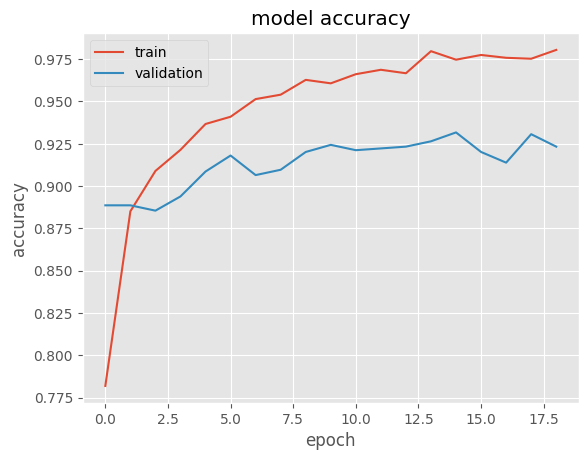

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
predictions = Model.predict(testGenerator)

119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [24]:
trainGenerator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [25]:
trueClasses = testGenerator.classes
trueClasses[:10]

[1, 3, 1, 4, 0, 3, 1, 0, 1, 1]

In [26]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([1, 3, 1, 4, 0, 3, 1, 0, 1, 1])

In [27]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9435 - loss: 0.2162


0.9317227005958557

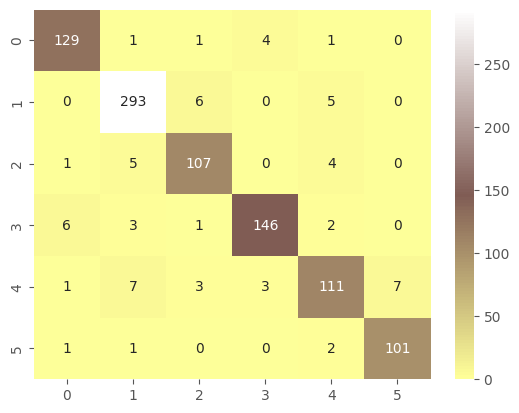

In [28]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [29]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       136
           1       0.95      0.96      0.95       304
           2       0.91      0.91      0.91       117
           3       0.95      0.92      0.94       158
           4       0.89      0.84      0.86       132
           5       0.94      0.96      0.95       105

    accuracy                           0.93       952
   macro avg       0.93      0.93      0.93       952
weighted avg       0.93      0.93      0.93       952



In [30]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index

    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index

    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


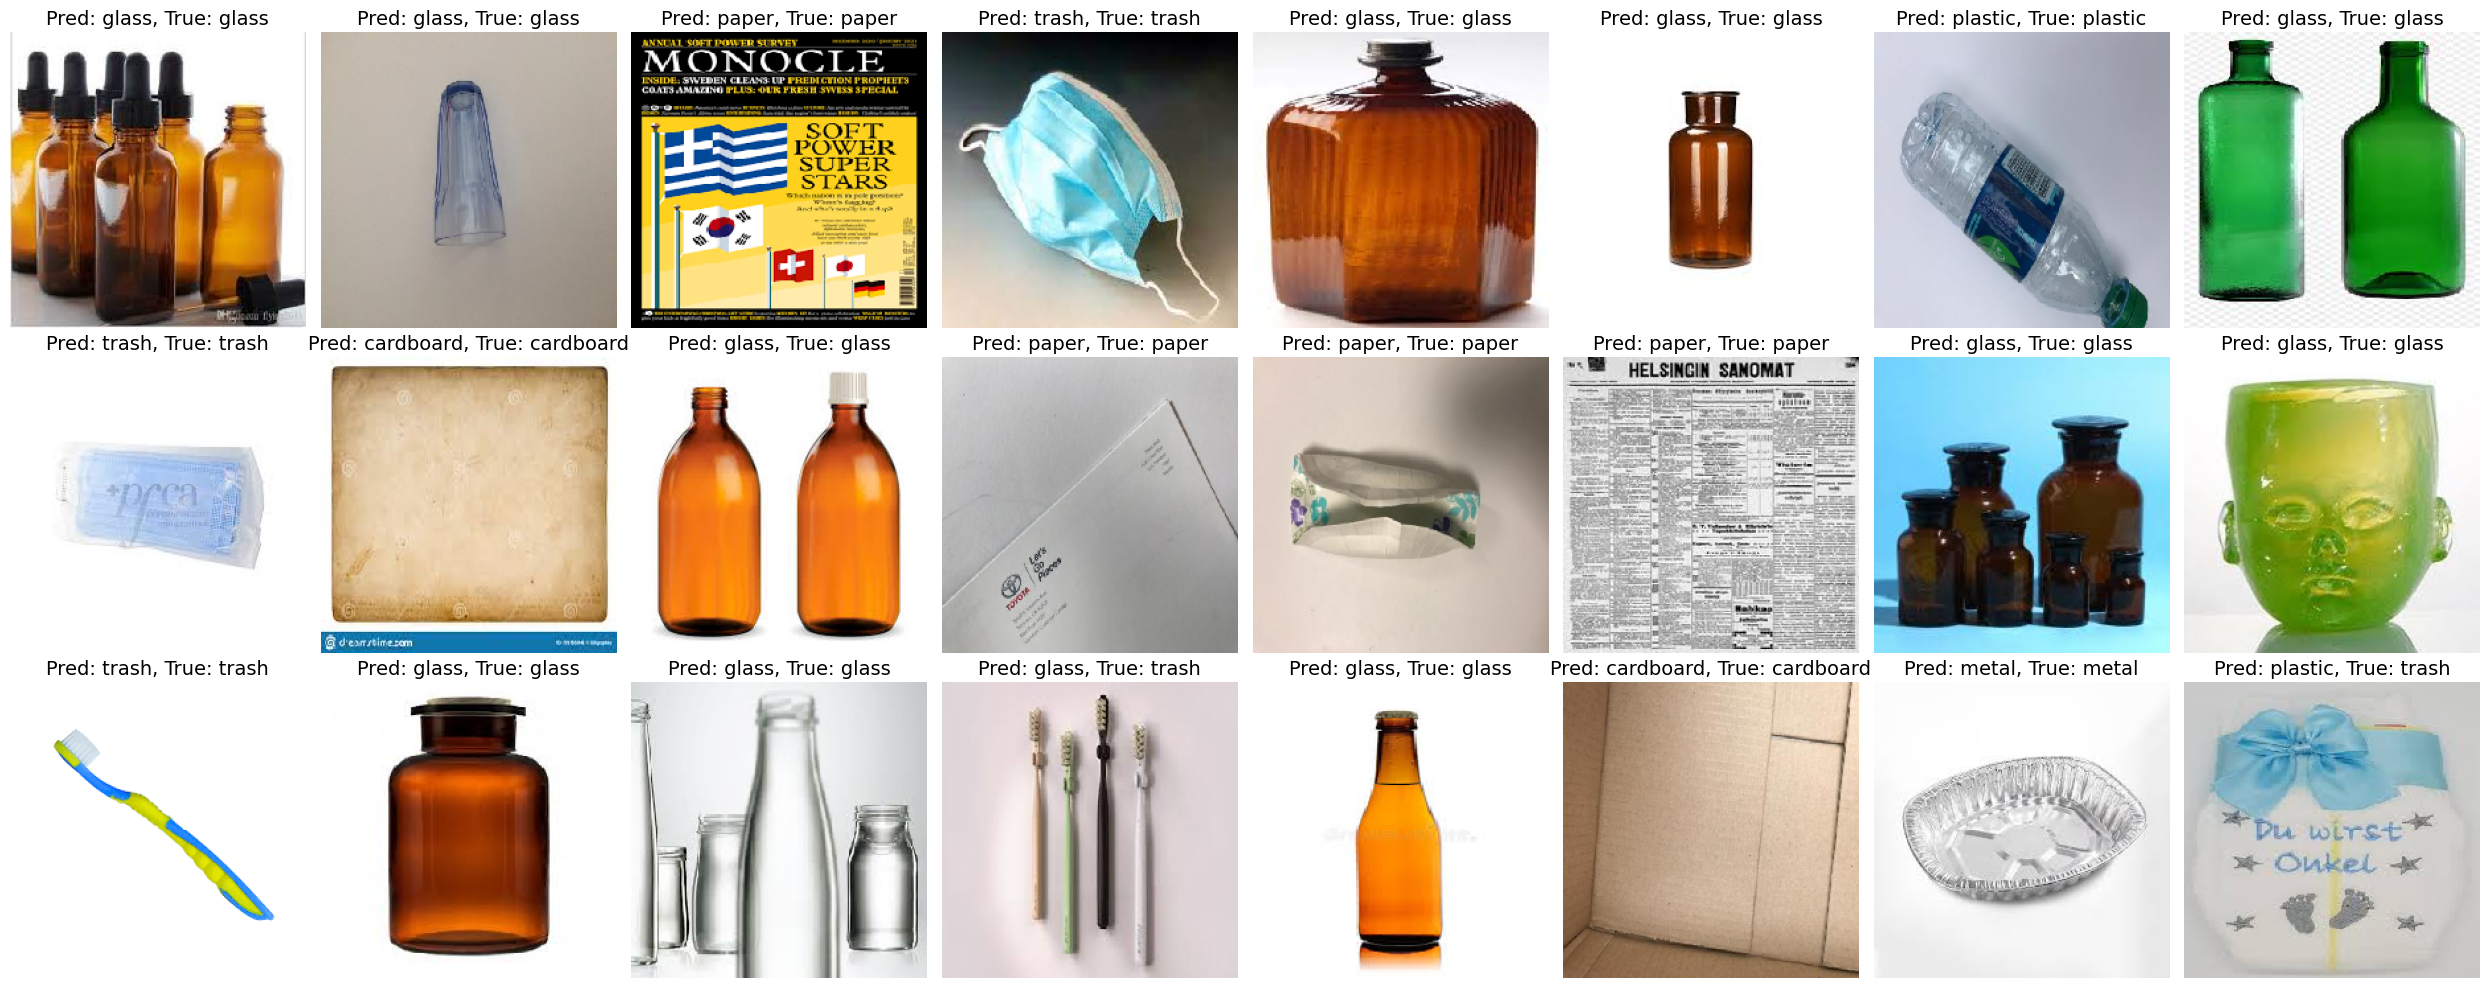

In [31]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Convert to TFlite

In [32]:
# # Menyimpan model ke file .h5
# model_path = '/content/drive/MyDrive/Capstone/garbage_classification_model.h5'
# Model.save(model_path)
# Menyimpan model ke dalam format .keras
model_path_keras = '/content/drive/MyDrive/Capstone/garbage_classification/garbage_model.keras' #menggunakan .keras karena lebih selaras untuk di konversi ke tflite
tf.keras.models.save_model(Model, model_path_keras)


In [33]:
# membuat konversi model ke tflite

# load model dulu
model_path_keras = '/content/drive/MyDrive/Capstone/garbage_classification/garbage_model.keras'
model = tf.keras.models.load_model(model_path_keras)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
tflite_model_path = '/content/drive/MyDrive/Capstone/garbage_classification/garbage_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpthljc5jq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  132016623100048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623111152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623114496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623106208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623108512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623121888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623122240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623124000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623118192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132016623122064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1320166231211

# Tflite Model for Classification

In [34]:

# load tflite nya dulu
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


In [35]:
# siapkan input
img_path = '/content/drive/MyDrive/Capstone/garbage_classification/data/plastic/plastic1.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255.0
input_data = np.expand_dims(img, axis=0)

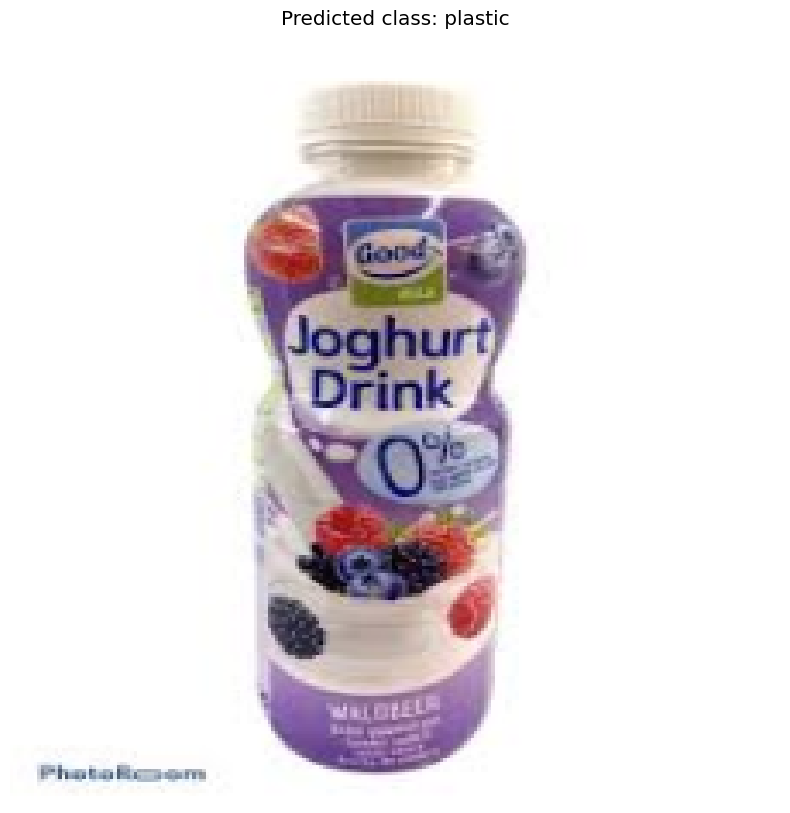

In [36]:

# Load the TFLite modelnya dulu
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data)
interpreter.invoke()
prediction = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

# ambil kelas prediksinya
class_labels = list(testGenerator.class_indices.keys())
predicted_class_index = np.argmax(prediction, axis=1)
predicted_class_label = class_labels[predicted_class_index[0]]

# Tampilin gambarny
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()

# Metadata Writer

In [37]:
%cd /content/drive/MyDrive/Capstone/garbage_classification/

!pwd

/content/drive/MyDrive/Capstone/garbage_classification
/content/drive/MyDrive/Capstone/garbage_classification


In [38]:
!wget https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/image_classification/metadata/metadata_writer_for_image_classifier.py


--2024-12-12 11:29:55--  https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/image_classification/metadata/metadata_writer_for_image_classifier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8129 (7.9K) [text/plain]
Saving to: ‘metadata_writer_for_image_classifier.py’

metadata_writer_for 100%[===================>]   7.94K  --.-KB/s    in 0.004s  

2024-12-12 11:29:56 (2.07 MB/s) - ‘metadata_writer_for_image_classifier.py’ saved [8129/8129]



In [2]:
# # import tensorflow as tf
!pip install tensorflow==2.8.0
!pip install tflite_support==0.4.4
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.8.0


In [6]:
# !python /content/drive/MyDrive/Capstone/metadata_writer_for_image_classifier.py \
#     --model_file=/content/drive/MyDrive/Capstone/garbage_model.tflite \
#     --label_file=/content/drive/MyDrive/Capstone/labels.txt \
#     --export_directory=/content/drive/MyDrive/Capstone/

!python /content/drive/MyDrive/Capstone/garbage_classification/metadata_writer_for_image_classifier.py \
    --model_file=/content/drive/MyDrive/Capstone/garbage_classification/garbage_model.tflite \
    --label_file=/content/drive/MyDrive/Capstone/garbage_classification/labels.txt \
    --export_directory=/content/drive/MyDrive/Capstone/garbage_classification/new_model_with_metadata


2024-12-12 11:37:04.226851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-12-12 11:37:08.208414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-12-12 11:37:08.209998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-12-12 11:37:08.210127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No